# Software Evolution - Practical Session
## Laws of software evolution, code counting, code duplication and dependency analysis
## Academic year 2022-2023

### Write your answers under the questions that are present in this notebook  

### Read Section 1 and Section 2 in the provided description document before proceeding with the following section 

In [30]:
import os
import json
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import math
from pandas import option_context
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## 2. Verifying laws of software evolution

In [3]:
#Enter the path where the Eucalyptus project is present
eucalyptus_project_path = '/home/data/informatique/git/umons/LawsSofware/eucalyptus'

### 2.1 Data prepocessing
1. Get all the tags present in the eucalyptus project using CLOC
2. Filter out the tags that do not correspond to official releases

Code hint:  
To get the tags that are present in the project - "command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'"   
To read the terminal output - 'process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)'

In [4]:
command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
all_tags = list(line.strip().decode('utf-8') for line in process.stdout)
print(all_tags)

['v4.4.2', 'v4.4.1', 'v4.4.0', 'v4.3.1.1', 'v4.3.1', 'v4.3.0.1', 'v4.3.0', 'v4.2.2', 'v4.2.1', 'v4.2.0', 'v4.1.2', 'v4.1.1', 'v4.1.0', 'v4.0.2', 'v4.0.1', 'v4.0.0', 'karmic', 'jaunty', 'ha-baseline', '3.4.2', '3.4.1', '3.4.0', '3.3-m6', '3.3-m5', '3.3-m4', '3.3-m3', '3.3-m2', '3.3-m1', '3.3.2', '3.3.1', '3.3.0.1', '3.3.0', '3.2.2', '3.2.1', '3.2.0', '3.1-beta1', '3.1-alpha2', '3.1.2', '3.1.1', '3.1.0', '3.0-rc3', '3.0-rc2', '3.0-rc1', '3.0-beta6', '3.0-beta5', '3.0-beta4', '3.0-beta3', '3.0-beta2', '3.0-alpha1', '3.0.1', '3.0.0', '2.0-branch', '2.0-beta', '2.0.1', '2.0.0', '1.6.1', '1.5.2', '1.5.1', '1.5.0', '1.4', '1.0-beta']


In [5]:
command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
all_tags = list(line.strip().decode('utf-8') for line in process.stdout)
v_list2 = []
v_list1 = []
for tag in all_tags:
    if re.match(r'v\d+\.\d+\.\d+', tag) is not None:
        v_list2.append(tag)
    elif re.match(r'\d+\.\d+\.\d+', tag) is not None:
        v_list1.append(tag)
print(v_list1)
print(v_list2)

['3.4.2', '3.4.1', '3.4.0', '3.3.2', '3.3.1', '3.3.0.1', '3.3.0', '3.2.2', '3.2.1', '3.2.0', '3.1.2', '3.1.1', '3.1.0', '3.0.1', '3.0.0', '2.0.1', '2.0.0', '1.6.1', '1.5.2', '1.5.1', '1.5.0']
['v4.4.2', 'v4.4.1', 'v4.4.0', 'v4.3.1.1', 'v4.3.1', 'v4.3.0.1', 'v4.3.0', 'v4.2.2', 'v4.2.1', 'v4.2.0', 'v4.1.2', 'v4.1.1', 'v4.1.0', 'v4.0.2', 'v4.0.1', 'v4.0.0']


### 2.2 Law of Increasing Growth
1. Fetch the required data (lines of code, blank lines, comment lines and number of files) for each tag along with their release date using CLOC
2. Separate the data as following (also mentioned in section 2.1 of the description document)  
    a) Consider all the three-component versions (major.minor.patch) - Dataset A  
    b) Consider only the minor versions (major.minor) - Dataset B  

Note: For example, if there exists any tag like 2.1.0.1, then you can consider it as 2.1.0 provided such a tag does not exist in the data. If both 2.1.0 and 2.1.0.1 exists, then you can ignore the latter 

Code hint:  
To set the project to a required tag - "command = f'git -C {project_path} reset --hard {tag}'"  
For each tag, pass the command to the terminal, invoke cloc tool to get the necessary data in the required format (json, md,...), read the terminal output and store the data

In [52]:
dataSetA = []
dataSetB = []
for tag in all_tags :
    if re.match(r'\d+\.\d+\.\d+$', tag) is not None or re.match(r'v\d+\.\d+\.\d+', tag) is not None :
        dataSetA.append(tag)
    elif re.match(r'\d+\.\d+$', tag) is not None or re.match(r'v\d+\.\d+', tag) is not None:
        dataSetB.append(tag) #['1.4']
print(dataSetA)
print(dataSetB)

['v4.4.2', 'v4.4.1', 'v4.4.0', 'v4.3.1.1', 'v4.3.1', 'v4.3.0.1', 'v4.3.0', 'v4.2.2', 'v4.2.1', 'v4.2.0', 'v4.1.2', 'v4.1.1', 'v4.1.0', 'v4.0.2', 'v4.0.1', 'v4.0.0', '3.4.2', '3.4.1', '3.4.0', '3.3.2', '3.3.1', '3.3.0', '3.2.2', '3.2.1', '3.2.0', '3.1.2', '3.1.1', '3.1.0', '3.0.1', '3.0.0', '2.0.1', '2.0.0', '1.6.1', '1.5.2', '1.5.1', '1.5.0']
['1.4']


In [8]:
static_major_minor_patch = ['v4.4.0','v4.3.0','v4.2.0','v4.1.0','v4.0.0','3.4.0','3.3.1', '3.2.0', '3.0.0','2.0.0', '1.6.1', '1.5.0']

In [9]:
static_major_minor = ['1.4']

In [54]:
command = f'cloc {eucalyptus_project_path} --csv --report-file=report.json'
process2 = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
print(process2)

<Popen: returncode: None args: 'cloc /home/data/informatique/git/umons/LawsS...>


#### Visualization
1. x-axis = version, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  



2. x-axis = date, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

For easy comparison, place the plots with the versions on x-axis should be on the top (0,0) and (1,0) and their corresponding plots with date on the x-axis right below them (1,0) and (1,1) 

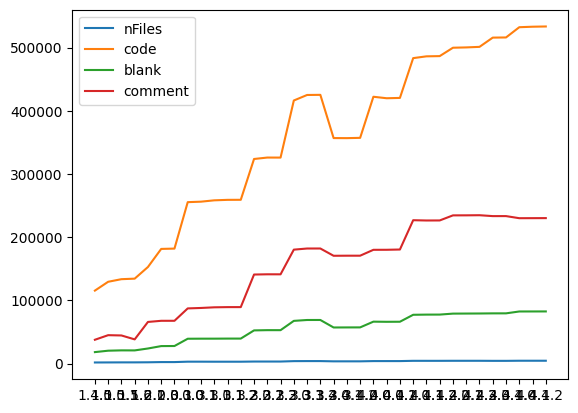

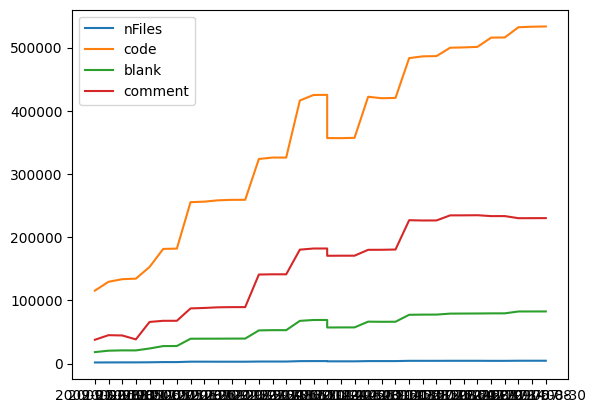

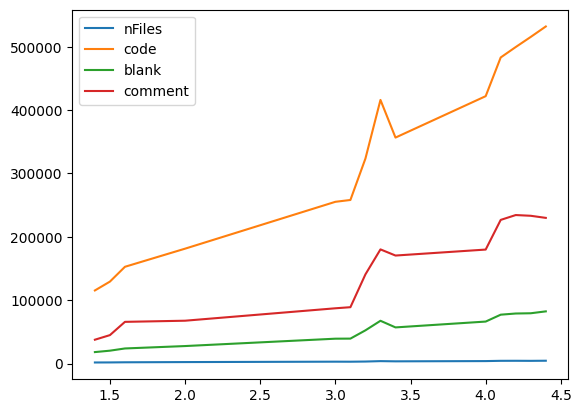

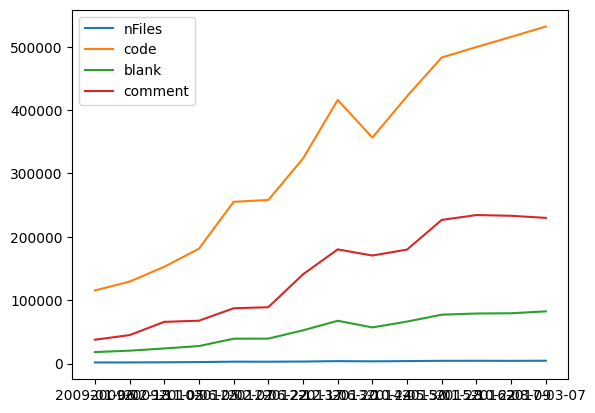

    Unnamed: 0  major  minor  patch  nb_code  nb_blank  nb_comment  nb_nfiles  \
0            0      1      4      0   115336     18033       37569       1624   
1            1      1      5      0   129319     20261       44820       1705   
2            2      1      5      1   133424     20780       44377       1784   
3            3      1      5      2   134275     20719       38184       1796   
4            4      1      6      1   152705     23755       65761       1923   
5            5      2      0      0   181316     27549       67567       2251   
6            6      2      0      1   181826     27681       67584       2255   
7            7      3      0      0   255305     39181       87179       2894   
8            8      3      0      1   256081     39290       87887       2896   
9            9      3      1      0   258194     39307       88912       2837   
10          10      3      1      1   258951     39420       89215       2840   
11          11      3      1

In [40]:
data_major_patch = pd.read_csv('/home/data/informatique/git/umons/LawsSofware/report/Umons_Course2023_SoftwareEvolutionTP2/LIG_major_minor_patch.csv')
data_major_minor = pd.read_csv('/home/data/informatique/git/umons/LawsSofware/report/Umons_Course2023_SoftwareEvolutionTP2/LIG_major_minor.csv')

plt.plot(data_major_patch['major.minor.patch'], data_major_patch['nb_nfiles'], label='nFiles')
plt.plot(data_major_patch['major.minor.patch'], data_major_patch['nb_code'], label='code')
plt.plot(data_major_patch['major.minor.patch'], data_major_patch['nb_blank'], label='blank')
plt.plot(data_major_patch['major.minor.patch'], data_major_patch['nb_comment'], label='comment')
plt.legend()

plt.show()

plt.plot(data_major_patch['date'], data_major_patch['nb_nfiles'], label='nFiles')
plt.plot(data_major_patch['date'], data_major_patch['nb_code'], label='code')
plt.plot(data_major_patch['date'], data_major_patch['nb_blank'], label='blank')
plt.plot(data_major_patch['date'], data_major_patch['nb_comment'], label='comment')
plt.legend()

plt.show()

plt.plot(data_major_minor['major.minor'], data_major_minor['nb_nfiles'], label='nFiles')
plt.plot(data_major_minor['major.minor'], data_major_minor['nb_code'], label='code')
plt.plot(data_major_minor['major.minor'], data_major_minor['nb_blank'], label='blank')
plt.plot(data_major_minor['major.minor'], data_major_minor['nb_comment'], label='comment')
plt.legend()

plt.show()

plt.plot(data_major_minor['date'], data_major_minor['nb_nfiles'], label='nFiles')
plt.plot(data_major_minor['date'], data_major_minor['nb_code'], label='code')
plt.plot(data_major_minor['date'], data_major_minor['nb_blank'], label='blank')
plt.plot(data_major_minor['date'], data_major_minor['nb_comment'], label='comment')
plt.legend()

plt.show()

print(data_major_patch)
print(data_major_minor)

### Questions:
1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?

We see a difference between the two graphs on the lines of: code, blank, how. This is because tags are not ordered by date. It can be seen that the tags are ordered alphabetically. That's why the lines of code, blank and how are higher for tags that are newer. We also see that with the dates, it is stable, and then it increases suddenly.


2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

Complicated to say, but I think it's the tag because we can see the version changes and therefore see the code changes. With the date, we cannot see the version changes, and therefore we cannot see the code changes.

3. Choose an option regarding the growth of the software by considering Dataset A (major.minor.patch). Motivate your choice using a 1d regression plot (below).
    a) Linear  
    b) Sub-linear
    c) Super-linear  

We can see very clearly that the dataSet is linear.

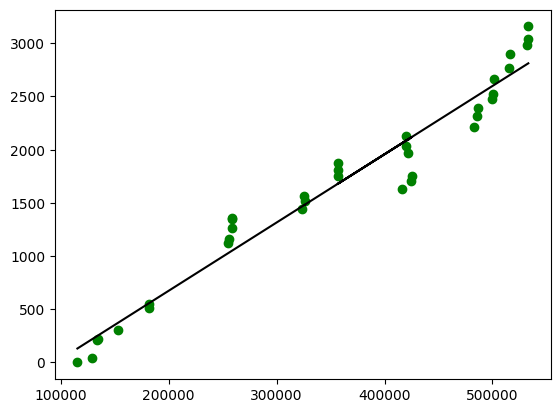

In [41]:
X = data_major_patch['nb_code'].values.reshape(-1, 1)
y = data_major_patch['relative_day'].values

model2 = LinearRegression()
model2.fit(X, y)

plt.scatter(X, y,color='g')
plt.plot(X, model2.predict(X),color='k')

plt.show()

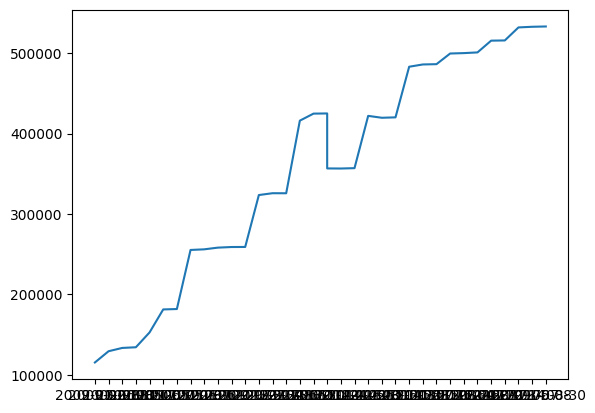

In [56]:
plt.figure()
plt.plot(data_major_patch['date'], data_major_patch['nb_code'])

### Correlation 
Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering Dataset A. Report the correlation upto 3 decimal places

In [12]:
print("PEARSON CORRELATION\n")
correlation = data_major_patch[['nb_code','nb_nfiles']].corr(method='pearson')
print(correlation)
print("-"*50)
print("SPEARMAN CORRELATION\n")
correlation2 = data_major_patch[['nb_code','nb_nfiles']].corr(method='spearman')
print(correlation2)

PEARSON CORRELATION

            nb_code  nb_nfiles
nb_code    1.000000   0.993107
nb_nfiles  0.993107   1.000000
--------------------------------------------------
SPEARMAN CORRELATION

            nb_code  nb_nfiles
nb_code    1.000000   0.977165
nb_nfiles  0.977165   1.000000


### Questions:
4. Do you find any difference in correlation values between Pearson and Spearman? Which one is preferable for this use case? why?

There is a very light difference between the two correlations. It can therefore be said that Pearson's correlation is preferable because it is more accurate.


5. Based on the above correlation value, how much is the number of lines of code related to the number of files?

The number of lines of code is related to the number of files by 0.999.

### Prediction
Consider Dataset A for this task. Drop the last two data points in "number of lines of code" (LOC) (i.e. drop (LOC) corresponding to v4.4.1 and v4.4.2) and forecast the values for (LOC) for v4.4.1 and v4.4.2 using a basic linear/polynimial regression model.
1. Drop the last two data points
2. Build a basic regression model
3. Ask the model to forecast the next two data points
4. Plot the LOC original and forecasted in the same plot. x-axis = date, y-axis = number of lines of code

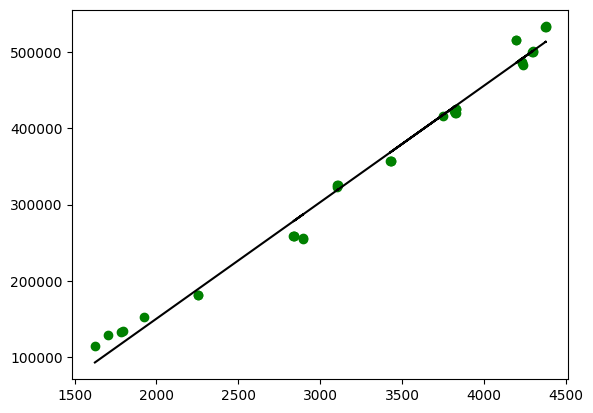

In [33]:
X = data_major_patch['nb_nfiles'].values.reshape(-1, 1)
y = data_major_patch['nb_code'].values

model2 = LinearRegression()
model2.fit(X, y)

plt.scatter(X, y,color='g')
plt.plot(X, model2.predict(X),color='k')

plt.show()

In [34]:
model_forecast = model2.predict(X)
print(model_forecast)

[ 93144.54908061 105502.87051686 117556.04821394 119386.91064894
 138763.53808601 188807.11130933 189417.39878767 286910.82345139
 287215.96719056 278214.22688514 278671.94249389 278824.51436347
 318950.91606388 319561.20354221 318950.91606388 417512.34381469
 429260.3777726  429260.3777726  368231.62993928 368994.4892872
 368994.4892872  428192.37468552 428497.51842468 429412.94964218
 492425.13178008 490746.84121466 490746.84121466 500969.15647674
 500816.58460716 501274.30021591 485864.541388   485559.39764883
 513327.47791299 513022.33417382 513174.90604341]


### Questions:
6. What is the polynomial degree that you adopted to build the model? Why? 

The polynomial degree that I adopted to build the model is 1 because the regression plot is a linear function. As for the previous regression plot, it is also a linear function. So, the polynomial degree is 1.

7. What is the coefficient of determination? (R-squared)

In [35]:
print(r2_score(y, model_forecast))

0.9862623093130586


8. What is the Root mean square error for the forecasted values?

In [36]:
print(mean_squared_error(y, model_forecast))

253021826.75841647


### Filtering on coding langugage

Consider the prominent langugages used in this software project and plot the distribution of their LOC in a pie chart for the first and the last versions

In [21]:
# cloc ../../eucalyptus/ --csv --out=data.csv

dataLgOLd = pd.read_csv('/home/data/informatique/git/umons/LawsSofware/report/Umons_Course2023_SoftwareEvolutionTP2/data_1.4.csv')
dataLgNew = pd.read_csv('/home/data/informatique/git/umons/LawsSofware/report/Umons_Course2023_SoftwareEvolutionTP2/data_v4.4.2.csv')
print(dataLgNew.head())
print(dataLgOLd['language'].unique())
print(dataLgNew['language'].unique())

list_of_lg = ['Java','C','Groovy','Python','Perl', 'HTML']
dataLgOLd2 = dataLgOLd[dataLgOLd['language'].isin(list_of_lg)]
dataLgNew2 = dataLgNew[dataLgNew['language'].isin(list_of_lg)]
print(dataLgOLd2.head())
print(dataLgNew2.head())

   files      language  blank  comment    code
0   1822          Java  33099    96395  210843
1     77             C   9915    26852   52724
2    255        Groovy   5671     9352   39327
3     47  Bourne Shell   1857     3916   15488
4    237           XML   2001     5477   15409
['Java' 'C' 'Groovy' 'Bourne Shell' 'XML' 'Perl' 'C/C++ Header'
 'Web Services Description' 'CSS' 'make' 'Ant' 'm4' 'Bourne Again Shell'
 'XSLT' 'HTML' 'JSON' 'INI' 'YAML' 'XSD' 'diff' 'CSV' 'SUM']
['Java' 'C' 'Groovy' 'Bourne Shell' 'XML' 'Python' 'Perl' 'C/C++ Header'
 'Web Services Description' 'CSS' 'make' 'Ant' 'm4' 'Bourne Again Shell'
 'XSLT' 'HTML' 'JSON' 'INI' 'YAML' 'XSD' 'diff' 'CSV' 'SUM']
    files language  blank  comment    code
0    1822     Java  33099    96395  210843
1      77        C   9915    26852   52724
2     255   Groovy   5671     9352   39327
5      44     Perl    779     2975    4422
14      5     HTML     52      142     165
   files language  blank  comment    code
0   1822     

([<matplotlib.patches.Wedge at 0x7f7817c142b0>,
 [Text(-0.5665020817211437, 0.9429079442902212, 'Java'),
  Text(0.04322728033797087, -1.0991503092091557, 'C'),
  Text(0.9019248467150841, -0.6297075280461337, 'Groovy'),
  Text(1.0870247789370315, -0.16845512748770108, 'Python'),
  Text(1.0987542607678942, -0.05233616765104901, 'Perl'),
  Text(1.0999984974471029, -0.0018181347905290328, 'HTML')])

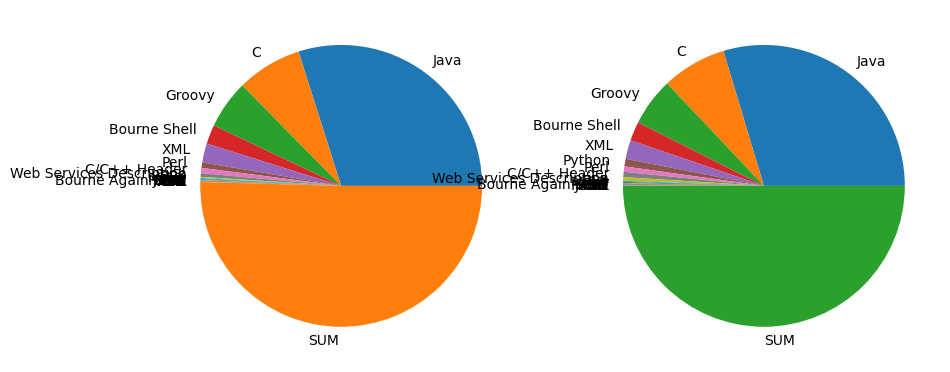

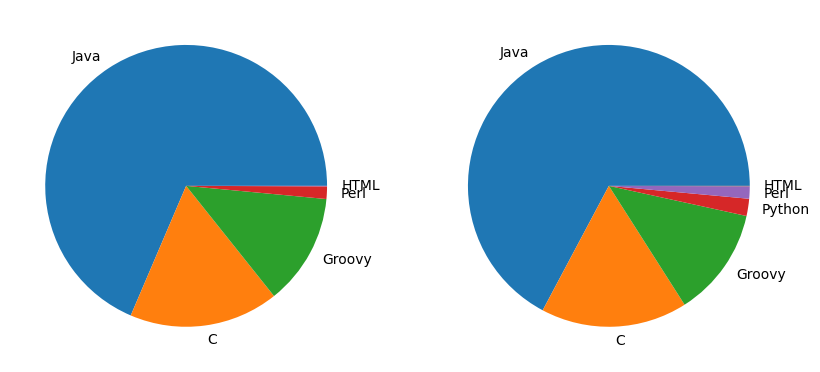

In [23]:
fig, axes = plt.subplots(1,2, figsize=(10,10))

axes[0].pie(dataLgOLd['code'], labels=dataLgOLd['language'])
axes[1].pie(dataLgNew['code'], labels=dataLgNew['language'])

fig2, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].pie(dataLgOLd2['code'], labels=dataLgOLd2['language'])
axes[1].pie(dataLgNew2['code'], labels=dataLgNew2['language'])

### Question:
9. Do you find any significant difference in the distribution of the language used in the software project between its first and the last version? If so, what is the difference and how much is it?

It is noted that the percentage of Java code to increase and that the code in c has decreased in the latest version. And we can also see the appearance of a new programming language, Python. This new programming language was used for 0.9% of the code.

### Law of increasing growth for coding langugages

Get the LOC for each of the considered prominent langugages (as above) for each version of the form major.minor.patch  
1) Plot the date (x-axis) vs LOC (y-axis) 
2) Plot the date (x-axis) vs proportional LOC (y-axis). Proportional is LOC of a language/total number of LOC

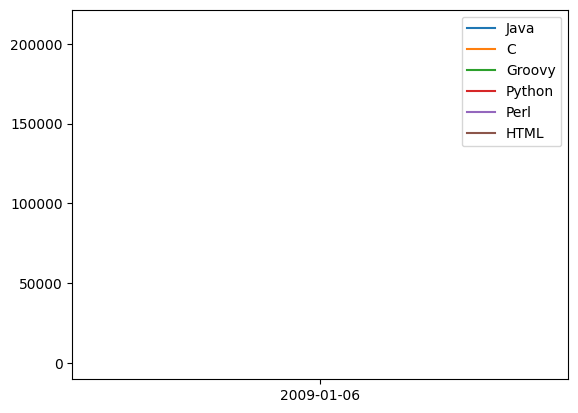

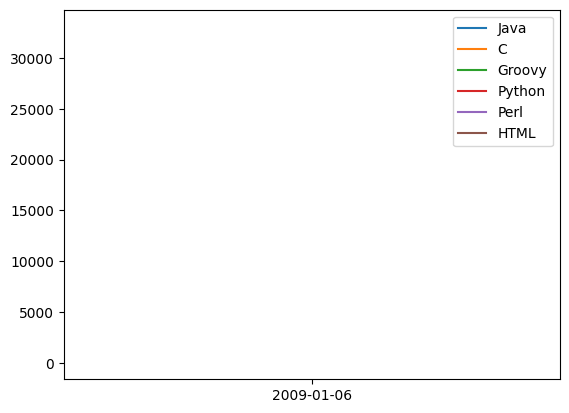

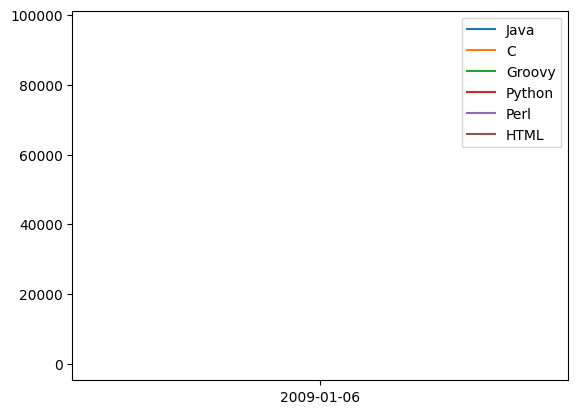

In [60]:
for l in list_of_lg:
    y = dataLgNew[dataLgNew['language'] == l]['code']
    plt.plot(data_major_patch['date'][0:len(y)], y, label=l)
plt.legend()
plt.show()

for l in list_of_lg:
    y = dataLgNew[dataLgNew['language'] == l]['blank']
    plt.plot(data_major_patch['date'][0:len(y)], y, label=l)
plt.legend()
plt.show()

for l in list_of_lg:
    y = dataLgNew[dataLgNew['language'] == l]['comment']
    plt.plot(data_major_patch['date'][0:len(y)], y, label=l)
plt.legend()
plt.show()

### Question:
10. Does the prominent languages considered by you obey laws of increasing growth?

Yes for java, there is indeed a very significant growth. For the c and groovy, there is less significant growth but still growth.

11. Does this software project obey the Law of Increasing Growth?

Yes, the software project obeys the Law of Increasing Growth. Indeed, the number of lines of code increases over time as shown in the graphs.

### Modify the CLOC parameters

1. Exclude all bank lines and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here #TODO

2. Exclude all comment lines and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here #TODO

3. Exclude all non-code files (or consider prominent coding langugages used in the project) and and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here #TODO

### 2.3 Law of Continuing Change
1. Using CLOC tool, find the features such as number of lines of code that are added, modified, removed and same between two consecutive versions
2. Consider all the three component versions (major.minor.patch) - Dataset A
3. Consider only the minor versions (major.minor) - Dataset B
4. Having all the features in the same plot, create two plots (one for Dataset A and another for Dataset B) the outcomes with date on x-axis and the number on y-axis.
5. Make a subplot of all the features

Code hint:  
For each pair of tags, set the original project to the required tag and the copy of the original project to the next tag.  
To get the required data in json format - "command = f'CLOC/cloc --git --diff {first_project_path} {second_project_path} --json'"

In [63]:
eucalyptus_copy_project_path = eucalyptus_project_path + "-1.4" # your path to the copy of your project here
major_minor_patch_versions = 'v4.4.2' #set of version that you would like to consider for this analysis
copy_version = '1.4'

In [80]:
# cloc --git --diff ../../eucalyptus-1.4 ../../eucalyptus --csv --out=data_compare.csv
df = pd.read_csv("/home/data/informatique/git/umons/LawsSofware/report/Umons_Course2023_SoftwareEvolutionTP2/data_compare.csv")
df.head()

,Language,== files,!= files,+ files,- files,== blank,!= blank,+ blank,- blank,== comment,!= comment,+ comment,- comment,== code,!= code,+ code,- code,Unnamed: 17
0,Perl,0,0,42,6,0,0,747,60,0,0,2842,53,0,0,4292,452,
1,Markdown,0,0,1,0,0,0,13,0,0,0,0,0,0,0,34,0,
2,make,0,0,17,10,0,0,308,131,0,0,952,64,0,0,986,332,
3,diff,0,0,2,2,0,0,32,8,0,0,86,20,0,0,41,11,
4,YAML,0,0,1,0,0,0,0,0,0,0,0,0,0,0,16,0,


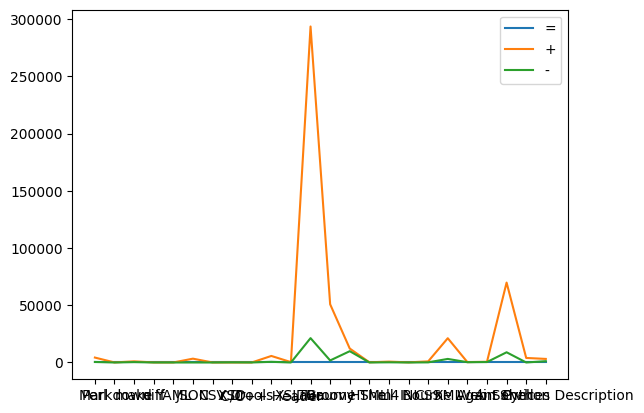

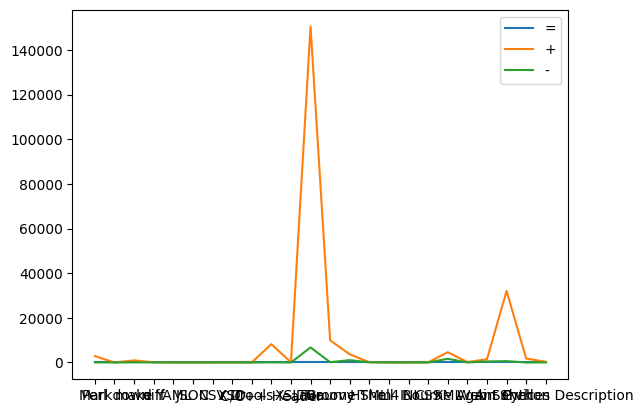

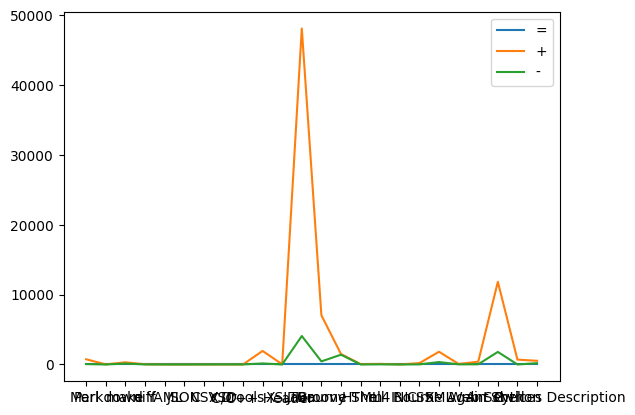

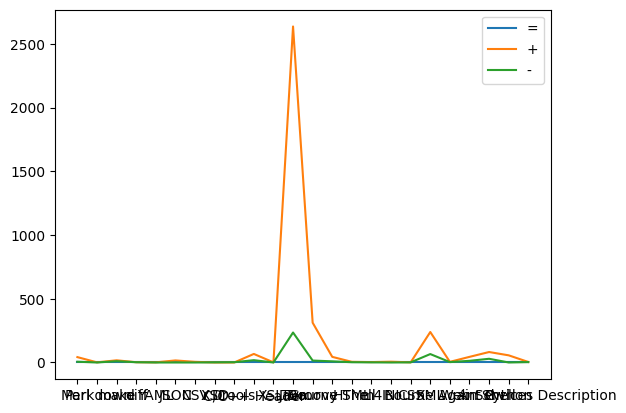

In [85]:
plt.plot(df['Language'], df[' == code'], label='=')
plt.plot(df['Language'], df[' + code'], label='+')
plt.plot(df['Language'], df[' - code'], label='-')
plt.legend()
plt.show()

plt.plot(df['Language'], df[' == comment'], label='=')
plt.plot(df['Language'], df[' + comment'], label='+')
plt.plot(df['Language'], df[' - comment'], label='-')
plt.legend()
plt.show()

plt.plot(df['Language'], df[' == blank'], label='=')
plt.plot(df['Language'], df[' + blank'], label='+')
plt.plot(df['Language'], df[' - blank'], label='-')
plt.legend()
plt.show()

plt.plot(df['Language'], df[' == files'], label='=')
plt.plot(df['Language'], df[' + files'], label='+')
plt.plot(df['Language'], df[' - files'], label='-')
plt.legend()
plt.show()

### Questions:
1. Do you find the Law of Continuing Change holding good here? Prove it empirically.

2. Does the law of increasing growth too hold good here?

### Law of continuing change for coding languages
Consider the prominent languages used in this software project for versions of the form major.minor.patch
1. Obtain the number of lines of code that are added, modified, removed and same between two consecutive versions
2. Make plots for each parameter (added, modified, removed and same) with date on x-axis  
    a) y-axis number of lines of code   
    b) y-axis proportional number of lines of code (number of lines of code of that language/total number of lines of code)

### Question:
3. Does the law of continuing change obey here for all the considered prominent langugages? Comment on the rate of growth.  

4. Does this software project obey Law of Continuing Change?